# Modelo de clasificación por tipo de espacio

### Importaciones

In [1]:
import numpy as np
import os
import PIL
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import seaborn as sn
import pandas as pd
from datetime import datetime

### Construcción de dataset

In [2]:
#Preprocesamiento de los datos
directory="E:/TesisMA/Datos/DataCombinada"
#directory1="E:/TesisMA/Datos/DataB"
img_height=256
img_width=256
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))

#val_mc= tf.keras.preprocessing.image_dataset_from_directory(
 # directory1,
  #seed=123,
  #image_size=(img_height, img_width))

Found 6506 files belonging to 5 classes.
Using 5205 files for training.
Found 6506 files belonging to 5 classes.
Using 1301 files for validation.


### Analisis del dataset

In [3]:
class_names = train_ds.class_names
print(class_names)


['bathroom', 'bedroom', 'dining_room', 'kitchen', 'living_room']


[1173, 1848, 472, 1157, 555, 0, 0, 0, 0]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

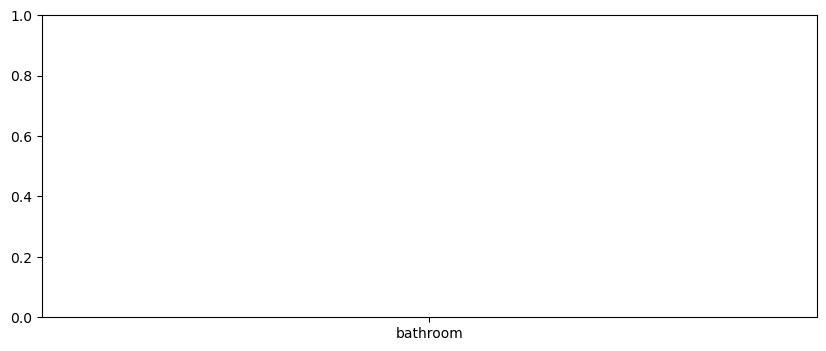

In [4]:
y = np.concatenate([y for x, y in train_ds], axis=0)
labels = list(y)
elements_per_class = []
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(0,9):
    elements_per_class.append(labels.count(i))
print(elements_per_class)
plt.bar(class_names,elements_per_class)

In [ ]:
labels1 = np.concatenate([y for x, y in val_ds], axis=0)
labels1 = list(labels1)
elements_per_class1 = []
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(0,9):
    elements_per_class1.append(labels1.count(i))
print(sum(elements_per_class1))
plt.bar(class_names,elements_per_class1)

In [ ]:
labels_mc = np.concatenate([y for x, y in val_mc], axis=0)
labels = list(labels_mc)
lista = []
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(0,9):
    lista.append(labels.count(i))
print(sum(lista))
plt.bar(class_names,lista)

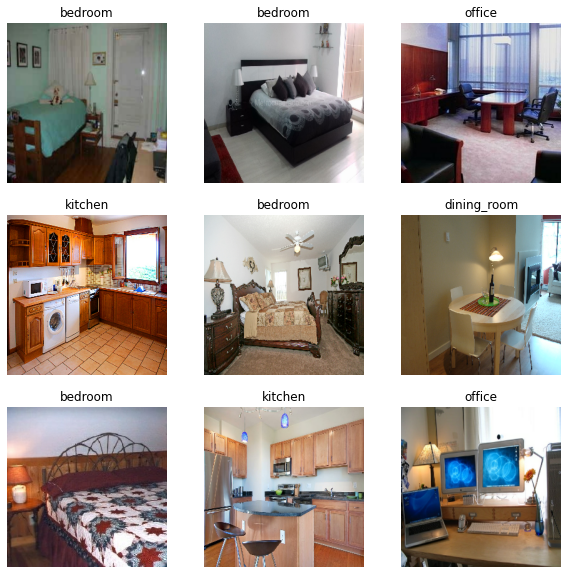

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

### CNN

In [10]:
num_classes = 9

model = Sequential([
  #Capa para realizar data augmantation
  data_augmentation,
  #Priemera capa entrada de 256x256 x3 canales de color
  layers.experimental.preprocessing.Rescaling(1/255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
 # layers.Dropout(0.1), #    Si empiza a haber ploblemas se pone el dropout 
  layers.Flatten(),
  layers.BatchNormalization(),
  layers.Dense(128, activation='relu', kernel_initializer="he_normal"),
  layers.BatchNormalization(),
  layers.Dense(64, activation='relu',kernel_initializer="he_normal"),
  layers.BatchNormalization(),
  layers.Dense(num_classes, activation='softmax')
])

In [11]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)       

In [16]:
weights = sklearn.utils.class_weight.compute_class_weight('balanced',np.arange(9),y)
weights

C:\Users\m.alvarezg1\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8], y=[2 5 3 ... 5 1 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([ 4.90935673,  0.61671258,  0.31781185,  1.01114122,  4.72292546,
        0.56276186,  1.32779755,  5.04204204, 10.08408408])

In [17]:
weights={}
for i in range(0,9):
    weights[i]=(1/elements_per_class[i])*(sum(elements_per_class)/9)
weights

{0: 4.909356725146198,
 1: 0.6167125803489439,
 2: 0.3178118493280333,
 3: 1.0111412225233363,
 4: 4.722925457102672,
 5: 0.562761856879504,
 6: 1.3277975484381177,
 7: 5.042042042042042,
 8: 10.084084084084084}

In [13]:
epochs=80
history = model.fit(
train_ds,
validation_data=val_ds,
epochs=epochs,
#class_weight=weights,
#callbacks=[tensorboard_cb]
)

Epoch 1/80
125/125 [==============================] - 500s 4s/step - loss: 2.0552 - accuracy: 0.2994 - val_loss: 1.8547 - val_accuracy: 0.3183
Epoch 2/80
125/125 [==============================] - 420s 3s/step - loss: 1.6499 - accuracy: 0.4155 - val_loss: 1.6653 - val_accuracy: 0.3844
Epoch 3/80
125/125 [==============================] - 424s 3s/step - loss: 1.5031 - accuracy: 0.4577 - val_loss: 1.6828 - val_accuracy: 0.3113
Epoch 4/80
125/125 [==============================] - 421s 3s/step - loss: 1.4206 - accuracy: 0.4847 - val_loss: 1.7909 - val_accuracy: 0.3664
Epoch 5/80
125/125 [==============================] - 419s 3s/step - loss: 1.3304 - accuracy: 0.5225 - val_loss: 1.7455 - val_accuracy: 0.4314
Epoch 6/80
125/125 [==============================] - 418s 3s/step - loss: 1.2704 - accuracy: 0.5450 - val_loss: 1.8581 - val_accuracy: 0.3924
Epoch 7/80
125/125 [==============================] - 421s 3s/step - loss: 1.2127 - accuracy: 0.5538 - val_loss: 1.9172 - val_accuracy: 0.3483

Epoch 58/80
125/125 [==============================] - 415s 3s/step - loss: 0.1260 - accuracy: 0.9622 - val_loss: 2.7730 - val_accuracy: 0.5045
Epoch 59/80
125/125 [==============================] - 416s 3s/step - loss: 0.1296 - accuracy: 0.9575 - val_loss: 2.5120 - val_accuracy: 0.5526
Epoch 60/80
125/125 [==============================] - 418s 3s/step - loss: 0.1176 - accuracy: 0.9622 - val_loss: 2.6399 - val_accuracy: 0.5435
Epoch 61/80
125/125 [==============================] - 416s 3s/step - loss: 0.1230 - accuracy: 0.9590 - val_loss: 2.4717 - val_accuracy: 0.5536
Epoch 62/80
125/125 [==============================] - 421s 3s/step - loss: 0.1371 - accuracy: 0.9535 - val_loss: 2.5683 - val_accuracy: 0.5506
Epoch 63/80
125/125 [==============================] - 415s 3s/step - loss: 0.1212 - accuracy: 0.9597 - val_loss: 2.6829 - val_accuracy: 0.5415
Epoch 64/80
125/125 [==============================] - 418s 3s/step - loss: 0.1176 - accuracy: 0.9637 - val_loss: 2.5274 - val_accuracy:

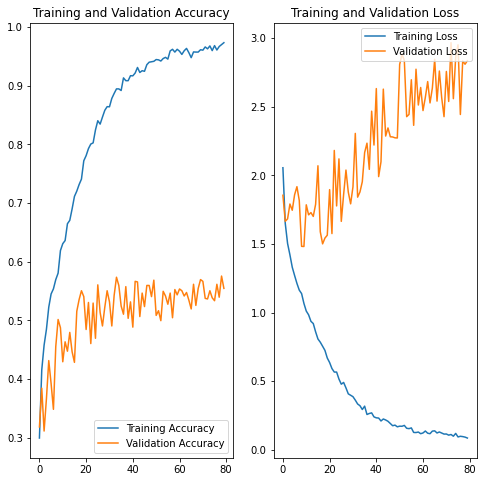

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Confusion matrix

<AxesSubplot:>

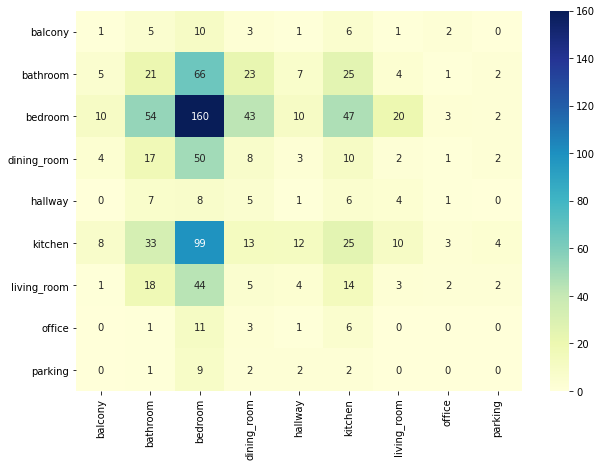

In [15]:
predictions = np.array([])
labels =  np.array([])
for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])  
                               
matriz = tf.math.confusion_matrix(labels=labels1, predictions=predictions).numpy()
sum(sum(matriz))
df_cm = pd.DataFrame(matriz, index = class_names, columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu",  fmt='g')

In [19]:
metricasCM(matriz)

De todas las X clasificadas solo el %  fue correcto [0.03, 0.13, 0.35, 0.08, 0.02, 0.18, 0.07, 0.0, 0.0]
De todas las que deberían ser clasificadas como X el % fue corrcto  [0.03, 0.14, 0.46, 0.08, 0.03, 0.12, 0.03, 0.0, 0.0]


### Evalucación del modelo usando datos de MC 

In [35]:
report = model.evaluate(val_mc,return_dict=True)
index=["Values"]
table=pd.DataFrame(report,index=index) 
table

NameError: name 'val_mc' is not defined

#### Confusion matrix

In [138]:
predictions = model.predict(val_mc)

<AxesSubplot:>

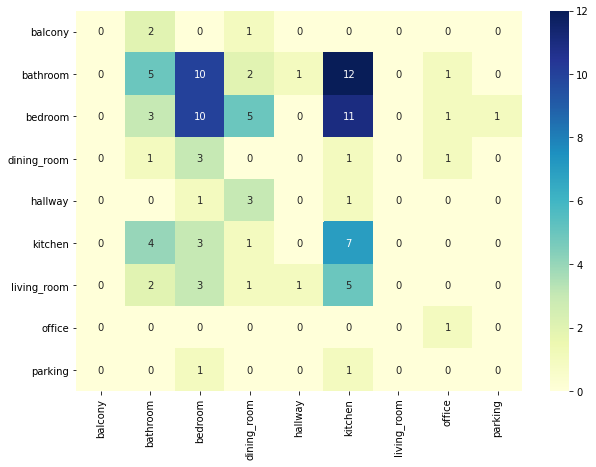

In [139]:
predictions=np.argmax(predictions,axis=1)
matriz = tf.math.confusion_matrix(labels=labels_mc, predictions=predictions).numpy()
sum(sum(matriz))
df_cm = pd.DataFrame(matriz, index = class_names, columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu",  fmt='g')

In [18]:
def metricasCM(matriz):
    # Bien clasificados sobre columna / De todas las X clasificadas solo el %  fue correcto
    metrica1= []
    # Bien clasificados sobre la fila / De todas las que deberías ser clasificadas como X solo el % fue corrcto 
    metrica2= []
    for j in range(0,9):
        suma=0
        for i in range(0,9):
            suma=suma+matriz[i][j]
        metrica1.append((matriz[j][j]/suma).round(2))
        metrica2.append((matriz[j][j]/sum(matriz[j])).round(2))
    print("De todas las X clasificadas solo el %  fue correcto",metrica1)
    print("De todas las que deberían ser clasificadas como X el % fue corrcto ",metrica2)
metricasCM(matriz)

De todas las X clasificadas solo el %  fue correcto [0.03, 0.13, 0.35, 0.08, 0.02, 0.18, 0.07, 0.0, 0.0]
De todas las que deberían ser clasificadas como X el % fue corrcto  [0.03, 0.14, 0.46, 0.08, 0.03, 0.12, 0.03, 0.0, 0.0]


#### TensorBoard

In [19]:
root_dir = "E:/TesisMA/Modelos/my_log"
def get_run_dir():
    import time
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%D")
    return os.path.join(root_dir,run_id)

tensorboard_cb = keras.callbacks.TensorBoard(get_run_dir())


In [20]:
%load_ext tensorboard
%tensorboard --logdir=E:/TesisMA/Modelos/my_log --port 6006

#### Guardar modelo

In [85]:
model.save("E:/TesisMA/Modelos/ModeloHe_normal")

INFO:tensorflow:Assets written to: E:/TesisMA/Modelos/ModeloHe_normal\assets


[5]
[[0.   0.14 0.08 0.11 0.01 0.6  0.03 0.02 0.  ]]
This image most likely belongs to kitchen with a 60.00 percent confidence.


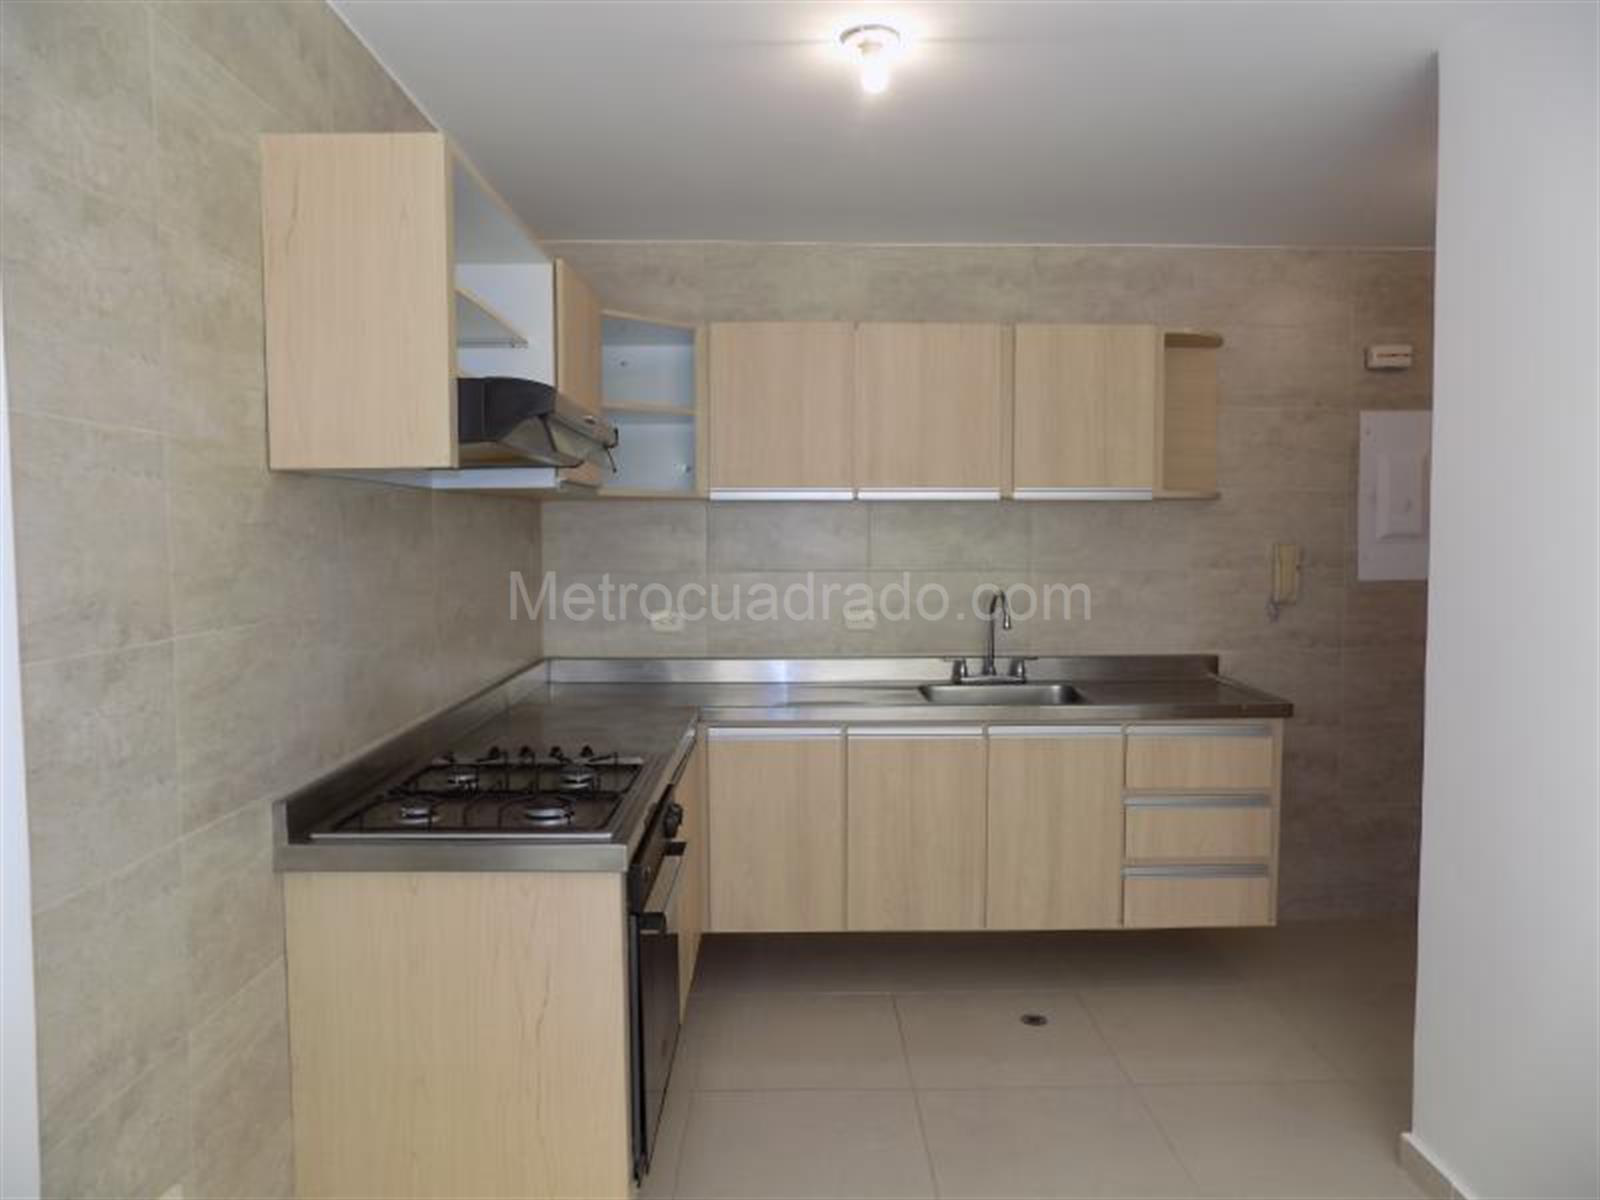

In [148]:
ruta = "C:/Users/m.alvarezg1/Documents/DataB/Apartamento1024_3.jpg"
img = keras.preprocessing.image.load_img(ruta
    , target_size=(256, 256)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
    
predictions = model.predict_classes(img_array)
predictions1 = model.predict(img_array).round(2)
print(predictions)
print(predictions1)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions1)], 100 * np.max(predictions1))
)
PIL.Image.open(ruta)

### Balanceando el dataset

In [1]:
iterator=train_ds.as_numpy_iterator()

NameError: name 'train_ds' is not defined